In [21]:
library(lme4)
library(pROC)
library(creditmodel)
library(usdm)

# Data preparation

In [14]:
setwd("~/DATA")
da= read.csv("data_extraction.csv", sep= ";")
da$X= NULL
da=na.omit(da)
colnames(da)= c("img", "y", "x", "p.a", "dem", "slope", "curvature", "planform_curvature", "profile_curvature", "NDVI", "BSI")

summary(da)
str(da)

     img                  y                x               p.a     
 Length:205476      Min.   :  0.00   Min.   :  0.00   Min.   :0.0  
 Class :character   1st Qu.: 31.00   1st Qu.: 31.00   1st Qu.:0.0  
 Mode  :character   Median : 64.00   Median : 64.00   Median :0.5  
                    Mean   : 63.72   Mean   : 63.73   Mean   :0.5  
                    3rd Qu.: 97.00   3rd Qu.: 97.00   3rd Qu.:1.0  
                    Max.   :127.00   Max.   :127.00   Max.   :1.0  
      dem                slope          curvature      planform_curvature
 Min.   :0.0007143   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000    
 1st Qu.:0.2902018   1st Qu.:0.3585   1st Qu.:0.4394   1st Qu.:0.4449    
 Median :0.4883852   Median :0.4587   Median :0.5016   Median :0.5103    
 Mean   :0.4901263   Mean   :0.4574   Mean   :0.5018   Mean   :0.5101    
 3rd Qu.:0.6883618   3rd Qu.:0.5581   3rd Qu.:0.5643   3rd Qu.:0.5752    
 Max.   :0.9988355   Max.   :0.9753   Max.   :1.0000   Max.   :1.0000    
 profi

'data.frame':	205476 obs. of  11 variables:
 $ img               : chr  "image_1" "image_1" "image_1" "image_1" ...
 $ y                 : int  3 2 19 67 113 10 123 38 0 127 ...
 $ x                 : int  29 126 94 10 98 43 112 123 63 115 ...
 $ p.a               : int  0 0 0 0 0 0 0 0 0 0 ...
 $ dem               : num  0.447 0.232 0.317 0.704 0.275 ...
 $ slope             : num  0.401 0.171 0.165 0.465 0.527 ...
 $ curvature         : num  0.371 0.329 0.353 0.344 0.267 ...
 $ planform_curvature: num  0.385 0.352 0.384 0.377 0.353 ...
 $ profile_curvature : num  0.565 0.593 0.588 0.594 0.675 ...
 $ NDVI              : num  0.641 0.4 0.66 0.603 0.621 ...
 $ BSI               : num  0.2333 0.379 0.1567 0.0812 0.2718 ...
 - attr(*, "na.action")= 'omit' Named int [1:1388] 134181 134182 134183 134184 134185 134186 134187 134188 134189 134190 ...
  ..- attr(*, "names")= chr [1:1388] "134181" "134182" "134183" "134184" ...


In [15]:
preds= sapply(da[c(5:11)], as.numeric)
vifpred=vifstep(preds, th=10) #Variance Inflation Factor
predictors=data.frame(exclude(preds, vifpred)) #predictors without collinearity problems
df= cbind(pa=da$p.a, predictors) #updated da

In [16]:
trainTestDf= train_test_split(df) #Split dataset into training and test
traindata <- data.frame(trainTestDf$train)
testdata <- data.frame(trainTestDf$test)

# Logistic regression

In [17]:
m1 <- glm(pa ~dem+slope+curvature+planform_curvature+profile_curvature+NDVI+BSI , data = traindata, family = binomial(link = "logit")) #fit the model
summary(m1)



Call:
glm(formula = pa ~ dem + slope + curvature + planform_curvature + 
    profile_curvature + NDVI + BSI, family = binomial(link = "logit"), 
    data = traindata)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.245  -1.178   1.131   1.176   1.234  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -0.21253    0.09322  -2.280   0.0226 *  
dem                 0.10808    0.02229   4.848 1.25e-06 ***
slope               0.15080    0.03578   4.215 2.50e-05 ***
curvature           0.06625    0.13186   0.502   0.6154    
planform_curvature -0.06032    0.08392  -0.719   0.4723    
profile_curvature   0.12227    0.10544   1.160   0.2462    
NDVI                0.01877    0.02270   0.827   0.4084    
BSI                 0.05302    0.03204   1.655   0.0980 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 199395  on 143832  degrees o

In [18]:
m1Predict <- predict(m1, testdata,type = "response") #Predictions

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 50.8779"


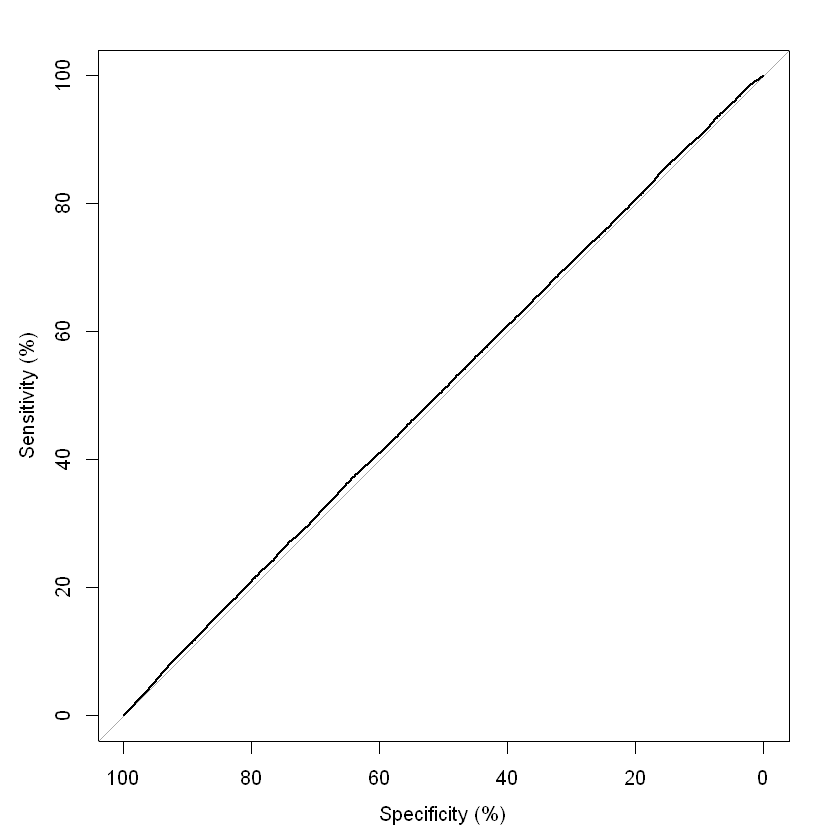

In [26]:
lrRoc <- pROC::roc(response=testdata$pa, predictor=m1Predict, plot=TRUE,percent = TRUE) #Roc curve
auc <- round(lrRoc$auc,digit = 4) #Calculate Area Under receiver operating Curve
plot(lrRoc)
print(paste("AUC:",auc))

In [28]:
#Calculate precision, recall and f1 (logistic regression)
result<- list()
table_mat<- list()
prec<- list()
rec<- list()
accuracy_Test<- list()


model <- m1
result <- m1Predict #predictions
table_mat <- table(testdata$pa, result > 0.5) #confusion matrix
accuracy_Test <- sum(diag(table_mat)) / sum(table_mat) #accuracy
precision <- function(matrix) {
  tp <- matrix[2, 2]# true positive
  fp <- matrix[1, 2]# false positive
  return (tp / (tp + fp)) #precision
}
prec <- precision(table_mat)
recall <- function(matrix) {
  tp <- matrix[2, 2] #true positive
  fn <- matrix[2, 1] #false negative
  return (tp / (tp + fn)) #recall
}
rec <- recall(table_mat)

accuracy=unlist(accuracy_Test)
accuracy=mean(accuracy)
print(paste("accuracy:", accuracy))

prec= unlist(prec)                
prec=mean(prec)
print(paste("precision:", prec))

rec=unlist(rec)
reSIc=mean(rec)
print(paste("recall:", rec))

f1 <- 2 * ((prec * rec) / (prec + rec)) #F1 score
print(paste("f1 score:", f1))

[1] "accuracy: 0.504550395016466"
[1] "precision: 0.503479155321595"
[1] "recall: 0.540833902050632"
[1] "f1 score: 0.521488444966706"


# Random forest

In [34]:
library(randomForest)

In [35]:
traindata$pa <- as.factor(traindata$pa) #convert response variable to factor in order to perform classification.

In [36]:
m2= randomForest(pa~dem+slope+curvature+planform_curvature+profile_curvature+NDVI+BSI, data=traindata,ntree=500, importance=TRUE) #fit the model

In [37]:
m2Predict <- factor(predict(m2, testdata,type = "response"), ordered = TRUE) #predict

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 55.7095"


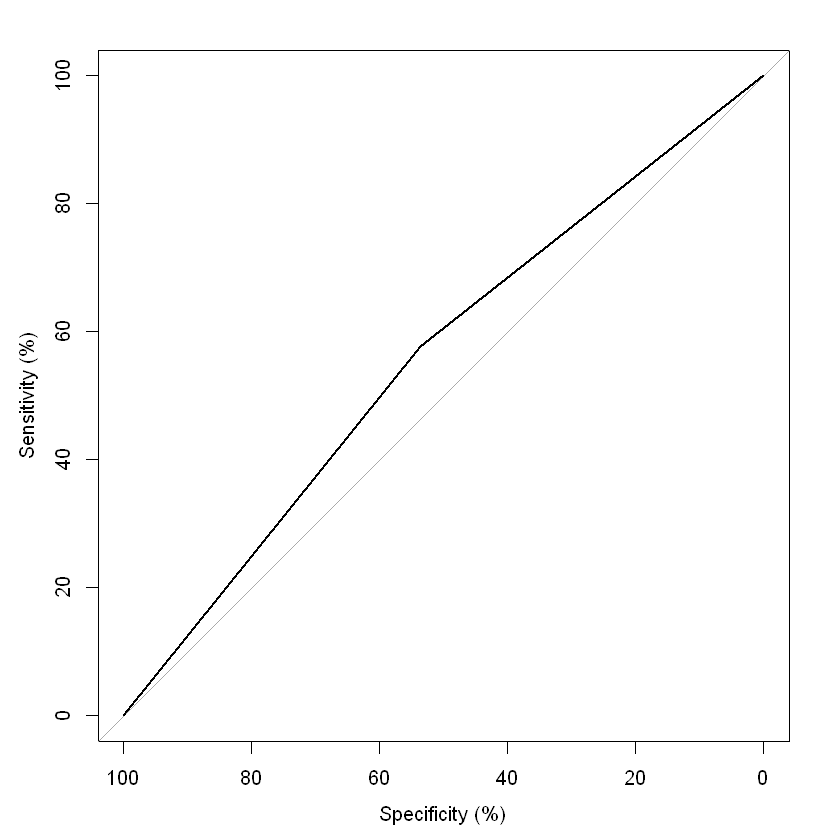

In [38]:
#ROC and AUC
lrRoc <- pROC::roc(response=testdata$pa, predictor = m2Predict, plot=TRUE,percent = TRUE)
auc <- round(lrRoc$auc,digit = 4)
plot(lrRoc)
print(paste("AUC:",auc))

In [41]:
#Calculate precision, recall and f1 (Random forest)
model <- m2
result <- as.numeric(m2Predict) #predictions
table_mat <- table(testdata$pa, result > 1.5) #confusion matrix
accuracy_Test <- sum(diag(table_mat)) / sum(table_mat) #accuracy
precision <- function(matrix) {
  tp <- matrix[2, 2]# true positive
  fp <- matrix[1, 2]# false positive
  return (tp / (tp + fp)) #precision
}
prec <- precision(table_mat)
recall <- function(matrix) {
  tp <- matrix[2, 2] #true positive
  fn <- matrix[2, 1] #false negative
  return (tp / (tp + fn)) #recall
}
rec <- recall(table_mat)

accuracy=unlist(accuracy_Test)
accuracy=mean(accuracy)
print(paste("accuracy:", accuracy))

prec= unlist(prec)                
prec=mean(prec)
print(paste("precision:", prec))

rec=unlist(rec)
reSIc=mean(rec)
print(paste("recall:", rec))

f1 <- 2 * ((prec * rec) / (prec + rec)) #F1 score
print(paste("f1 score:", f1))

[1] "accuracy: 0.557062440179745"
[1] "precision: 0.554119446785926"
[1] "recall: 0.576809333463326"
[1] "f1 score: 0.565236775898857"
